In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import string
from nltk.tokenize import word_tokenize


In [2]:
data = pd.read_csv('all_data.csv')
data.columns
toxicity_columns = ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat']

# Plot distribution of toxicity scores

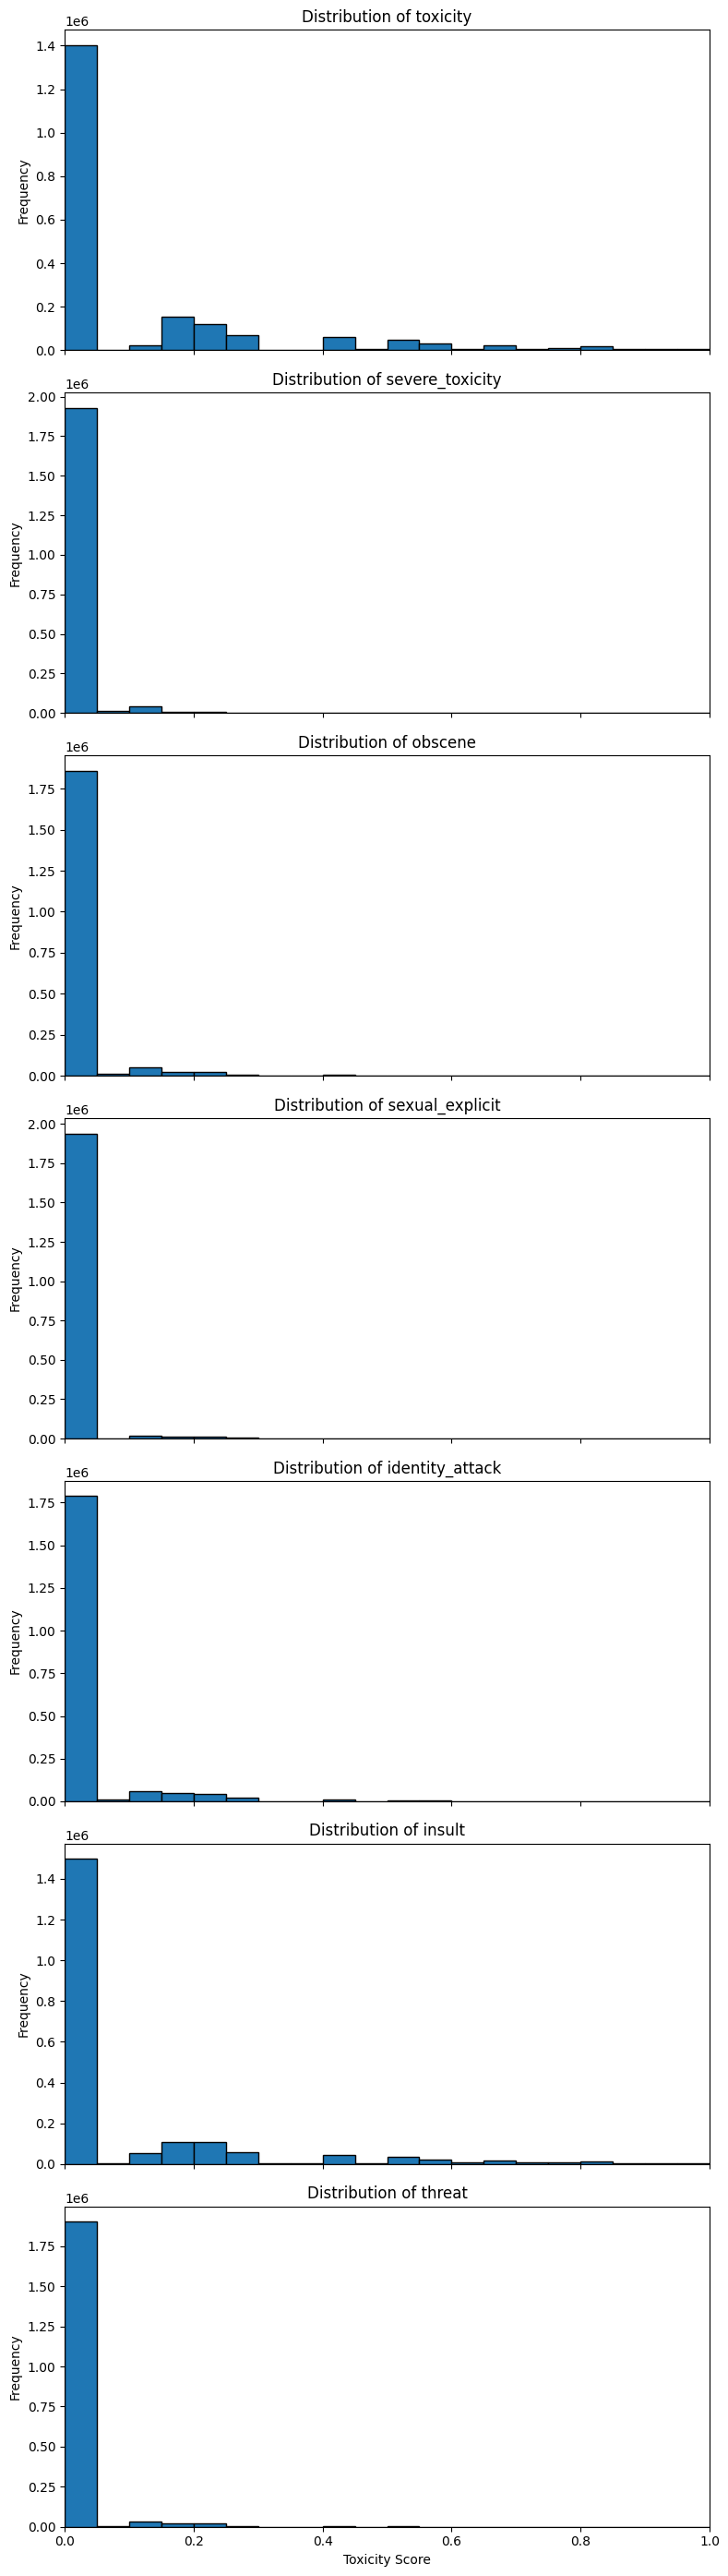

In [3]:
# Create a figure and a grid of subplots
fig, axes = plt.subplots(len(toxicity_columns), 1, figsize=(8, 4*len(toxicity_columns)), sharex=True)
# Iterate over each toxicity column and plot the distribution
for i, column in enumerate(toxicity_columns):
    axes[i].hist(data[column], bins=20, range=(0, 1), edgecolor='black')
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(0, 1)

# Set the x-label for the last subplot
axes[-1].set_xlabel('Toxicity Score')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

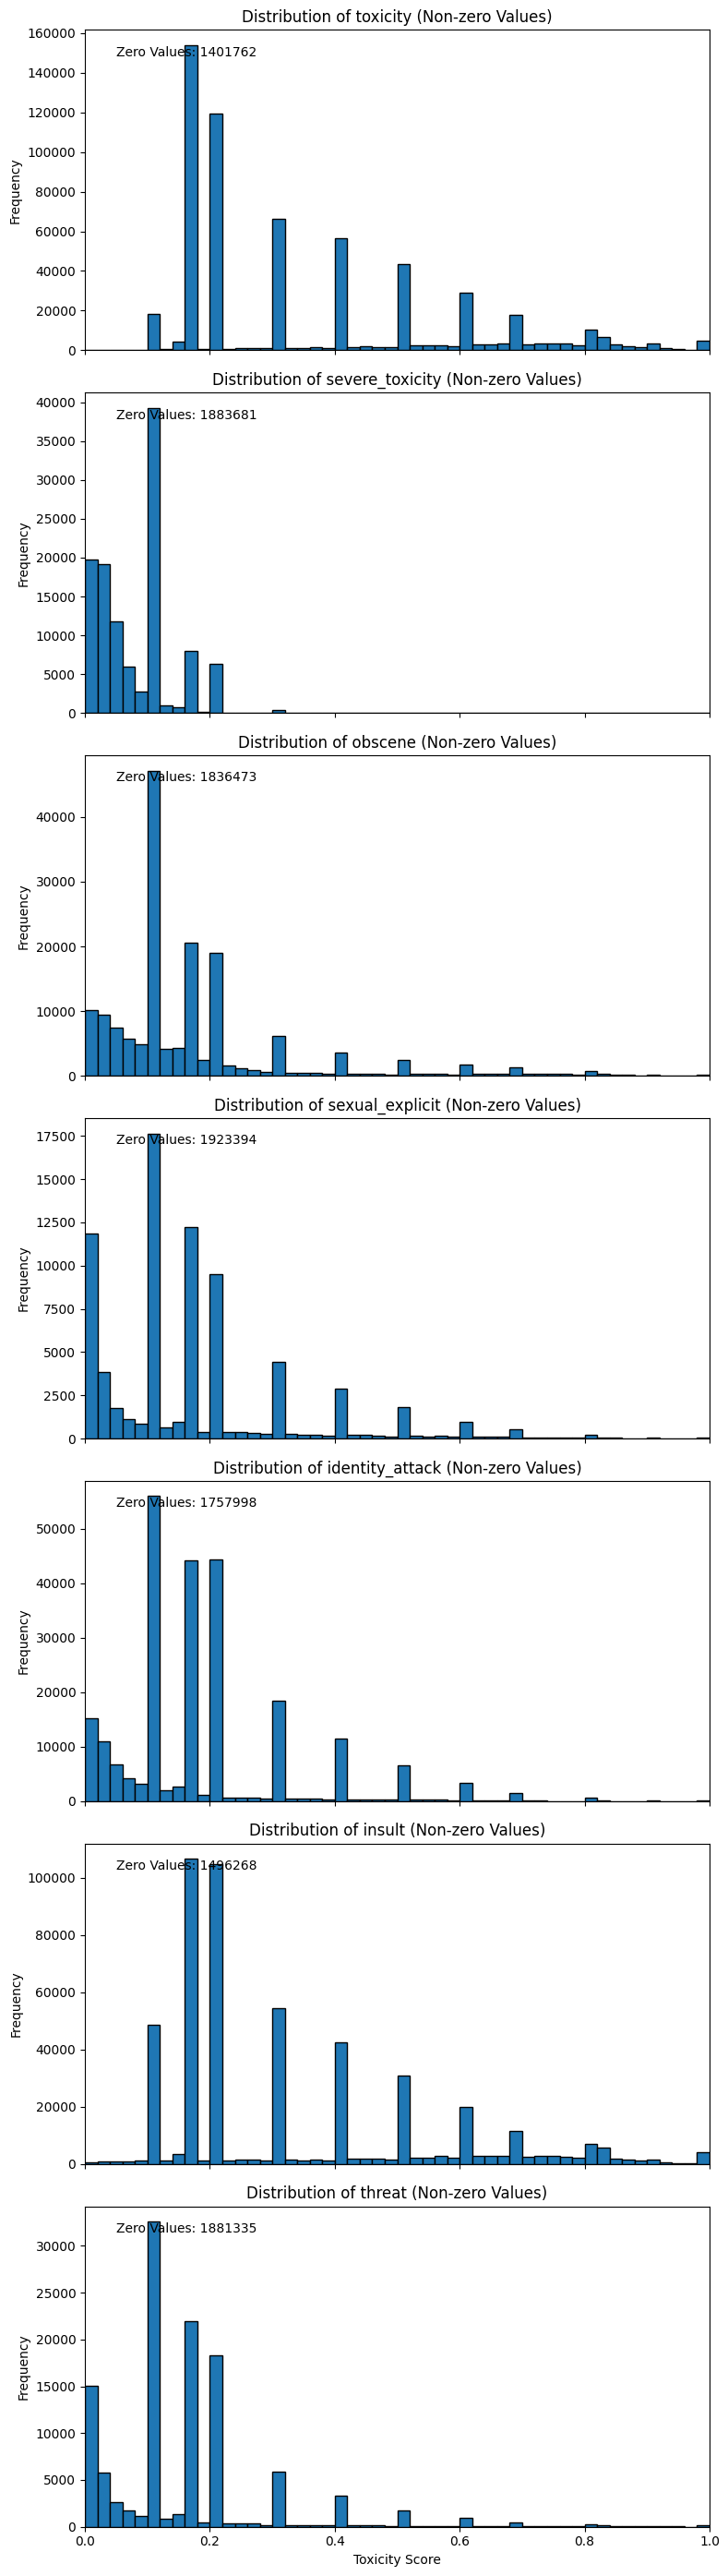

In [4]:
# Create a figure and a grid of subplots
fig, axes = plt.subplots(len(toxicity_columns), 1, figsize=(8, 4*len(toxicity_columns)), sharex=True)

# Iterate over each toxicity column and plot the distribution
for i, column in enumerate(toxicity_columns):
    # Count the number of zero values
    zero_count = (data[column] == 0).sum()
    
    # Plot the distribution of non-zero values
    non_zero_data = data[data[column] != 0][column]
    axes[i].hist(non_zero_data, bins=50, range=(0, 1), edgecolor='black')
    axes[i].set_title(f'Distribution of {column} (Non-zero Values)')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(0, 1)
    
    # Display the count of zero values
    axes[i].text(0.05, 0.95, f'Zero Values: {zero_count}', transform=axes[i].transAxes, verticalalignment='top')

# Set the x-label for the last subplot
axes[-1].set_xlabel('Toxicity Score')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

We see that the distribution of toxicity scores is highly imbalanced. It is mostly concentrated around 0.0 and 0.5. This is a challenge for training a model to predict toxicity. We will need to use techniques to handle imbalanced data.

# Preprocess
To consider the distribution of toxicity scores across all identified columns, I will try here to create a new column that aggregates all toxicity scores into one. This will allow us to see the distribution of toxicity scores across all identified columns.

Create column that calculates max toxicity score across all identified columns.

In [5]:
data['combined_toxicity'] = data[toxicity_columns].max(axis=1)

Create a binary column that indicates if the max toxicity score is greater than 0.

In [6]:
data['binary_toxicity'] = data['combined_toxicity'].apply(lambda x: 1 if x > 0 else 0)

Balance the dataset by downsampling the majority class.

In [7]:
toxic_count = (data['binary_toxicity'] == 1).sum()
non_toxic_count = (data['binary_toxicity'] == 0).sum()
print(f"Number of toxic comments: {toxic_count}")
print(f"Number of non-toxic comments: {non_toxic_count}")

Number of toxic comments: 622373
Number of non-toxic comments: 1377143


In [8]:
# Determine the desired number of samples for each class
desired_samples = min(toxic_count, non_toxic_count)

In [9]:
# Randomly sample an equal number of toxic and non-toxic comments
toxic_data = data[data['binary_toxicity'] == 1].sample(n=desired_samples, random_state=42)
non_toxic_data = data[data['binary_toxicity'] == 0].sample(n=desired_samples, random_state=42)
balanced_data = pd.concat([toxic_data, non_toxic_data])

In [10]:
balanced_data = balanced_data.sample(frac=1, random_state=42)

# Text cleaning

Perform train-validation-test split.

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train_data, test_data = train_test_split(balanced_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

pip install transformers

python -m spacy download en_core_web_sm

pip install emoji

In [13]:
from transformers import BertTokenizer
import spacy
from emoji import demojize

C:\Users\CasKei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
nlp = spacy.load('en_core_web_sm')

In [15]:
def preprocess_text(text):
    if isinstance(text, float):  # Check if the input is a float
        text = str(text)  # Convert float to string

    text = demojize(text)
    # Tokenise text with spaCy
    doc = nlp(text)
    # Preprocess with spaCy
    tokens = [token.text.lower() for token in doc if not token.is_punct and not token.is_stop]
    
    # Join the tokens back together
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text
    

In [16]:
train_data['preprocessed_text'] = train_data['comment_text'].apply(preprocess_text)
val_data['preprocessed_text'] = val_data['comment_text'].apply(preprocess_text)
test_data['preprocessed_text'] = test_data['comment_text'].apply(preprocess_text)

Tokenize text data using BERT tokenizer's batch_encode_plus method.

In [17]:
def tokenize_data(data):
    return tokenizer.batch_encode_plus(
        data,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

In [18]:
train_encodings = tokenize_data(train_data['preprocessed_text'].tolist())
val_encodings = tokenize_data(val_data['preprocessed_text'].tolist())
test_encodings = tokenize_data(test_data['preprocessed_text'].tolist())

Prepare the labels for the model. Extract the binary toxicity labels from each split dataset.

In [19]:
train_labels = train_data['binary_toxicity'].tolist()
val_labels = val_data['binary_toxicity'].tolist()
test_labels = test_data['binary_toxicity'].tolist()

# BERT training

pip install torch transformers


In [20]:
import torch
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

In [21]:
# Load model and specify number of output labels as 2 (toxic and non-toxic)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [23]:
# Prepare optimiser and learning rate scheduler
optimiser = AdamW(model.parameters(), lr=1e-3)
num_train_steps = len(train_encodings['input_ids']) // 16 * 10 # 32 is the batch size, 10 is the number of epochs

C:\Users\CasKei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Create PyTorch dataset and dataloader.

In [24]:
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels)
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels)
)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

C:\Users\CasKei\AppData\Local\Temp\ipykernel_4856\2778340662.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['input_ids']),
C:\Users\CasKei\AppData\Local\Temp\ipykernel_4856\2778340662.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['attention_mask']),
C:\Users\CasKei\AppData\Local\Temp\ipykernel_4856\2778340662.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_encodings['input_ids']),
C:\Users\CasKei\AppData\Local\Temp\ipykernel_4856\2778340662.py:10: Us

Fine-tune BERT model on the training set.
In each epoch, interate over the training dataloader, perform forward and backward pass, update the model parameters, and step the optimiser. Also evaluate the model on the validation set after each epoch and print validation loss.

In [25]:
from tqdm import tqdm
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", unit="batch"):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        
        optimiser.step()
        optimiser.zero_grad()
        
        train_losses.append(loss.item())

    # Calculate training loss for the epoch
    train_loss = sum(train_losses) / len(train_loader)
    
    model.eval()
    
    with torch.no_grad():
        valid_losses = []
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", unit="batch"):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            valid_losses.append(outputs.loss.item())
    
    # Calculate validation loss for the epoch
    valid_loss = sum(valid_losses) / len(val_loader)
    
    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")


Validation Epoch 1/10: 100%|██████████| 12448/12448 [04:47<00:00, 43.27batch/s]


Epoch 1, Training Loss: 0.6988, Validation Loss: 0.6934


Validation Epoch 2/10: 100%|██████████| 12448/12448 [04:46<00:00, 43.46batch/s]


Epoch 2, Training Loss: 0.6942, Validation Loss: 0.6957


Validation Epoch 3/10: 100%|██████████| 12448/12448 [04:51<00:00, 42.74batch/s]


Epoch 3, Training Loss: 0.6950, Validation Loss: 0.6970


Validation Epoch 4/10: 100%|██████████| 12448/12448 [04:49<00:00, 43.06batch/s]


Epoch 4, Training Loss: 0.6952, Validation Loss: 0.6937


Validation Epoch 5/10: 100%|██████████| 12448/12448 [04:42<00:00, 44.07batch/s]


Epoch 5, Training Loss: 0.6954, Validation Loss: 0.6943


Validation Epoch 6/10: 100%|██████████| 12448/12448 [04:42<00:00, 44.06batch/s]


Epoch 6, Training Loss: 0.6955, Validation Loss: 0.6932


Validation Epoch 7/10: 100%|██████████| 12448/12448 [04:42<00:00, 44.09batch/s]


Epoch 7, Training Loss: 0.6954, Validation Loss: 0.6934


Validation Epoch 8/10: 100%|██████████| 12448/12448 [04:41<00:00, 44.27batch/s]


Epoch 8, Training Loss: 0.6954, Validation Loss: 0.6939


Validation Epoch 9/10: 100%|██████████| 12448/12448 [04:41<00:00, 44.28batch/s]


Epoch 9, Training Loss: 0.6954, Validation Loss: 0.6933


Validation Epoch 10/10: 100%|██████████| 12448/12448 [04:41<00:00, 44.29batch/s]

Epoch 10, Training Loss: 0.6954, Validation Loss: 0.6952


Evaluate the model on the test set.

In [26]:
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(test_labels)
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc=f"Testing Epoch {epoch+1}/{num_epochs}", unit="batch"):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

C:\Users\CasKei\AppData\Local\Temp\ipykernel_4856\4234282779.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(test_encodings['input_ids']),
C:\Users\CasKei\AppData\Local\Temp\ipykernel_4856\4234282779.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(test_encodings['attention_mask']),
Testing Epoch 10/10: 100%|██████████| 15560/15560 [05:52<00:00, 44.18batch/s]


Test Accuracy: 0.4994
Test F1 Score: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000


C:\Users\CasKei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
